In [1]:
## Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
from tkinter import Tk
import tkinter
import imagecodecs
from tkinter.filedialog import askopenfilename
import os
from skimage import filters, measure, morphology, draw
import math
import pandas as pd

In [2]:
tkinter._test()
plt.close('all')

In [3]:
# Use tkinter to open a file dialog and select one of the images
def select_file():
    Tk().withdraw()  # We don't want a full GUI, so keep the root window from appearing
    filename = askopenfilename(title="Select a Channel 1 TIFF Image", filetypes=[("TIFF files", "*.tif *.tiff *.tf2 *.tf1")])
    return filename

# Select a file using the file dialog
selected_file = select_file()

In [4]:
# Generate filenames for the other channels based on the selected file
base_name = os.path.splitext(selected_file)[0]
channel1_path = selected_file
channel2_path = base_name.replace("_w1sdc405", "_w2sdc488") + os.path.splitext(selected_file)[1]
channel3_path = base_name.replace("_w1sdc405", "_w3sdc561") + os.path.splitext(selected_file)[1]
# channel4_path = base_name.replace("_w1sdc405.ome.tf2", "CH4") + os.path.splitext(selected_file)[1]

# Load the images
channel1 = tiff.imread(channel1_path)
channel2 = tiff.imread(channel2_path)
channel3 = tiff.imread(channel3_path)
# channel4 = tiff.imread(channel4_path)

# Combine channels into a single multi-channel image for convenience
# image = np.stack((channel1, channel2, channel3, channel4), axis=-1)

image = np.stack((channel1, channel2, channel3), axis=-1)


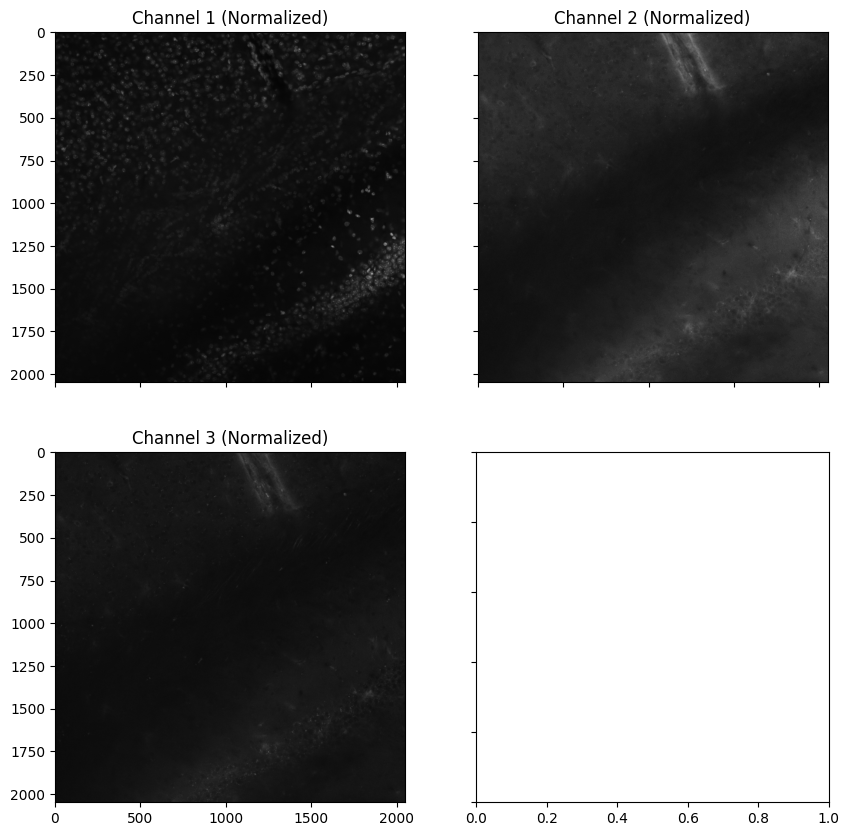

In [5]:

# Normalize images for display
def normalize(image):
    return (image - np.min(image)) / (np.max(image) - np.min(image))

fig, axs = plt.subplots(2, 2,figsize=(10,10))

# Display one of the channels (normalized)
axs[0,0].imshow(normalize(tiff.imread(channel1_path)), cmap='gray')
axs[0,0].set_title('Channel 1 (Normalized)')
axs[0,1].imshow(normalize(tiff.imread(channel2_path)), cmap='gray')
axs[0,1].set_title('Channel 2 (Normalized)')
axs[1,0].imshow(normalize(tiff.imread(channel3_path)), cmap='gray')
axs[1,0].set_title('Channel 3 (Normalized)')
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.show()
# # Display one of the channels (normalized)
# plt.imshow(normalize(channel4), cmap='gray')
# plt.title('Channel 4 (Normalized)')
# plt.show()

In [6]:
print(np.mean(channel1)) 

329.0067172050476


the amount of found Background ROIs is:56236


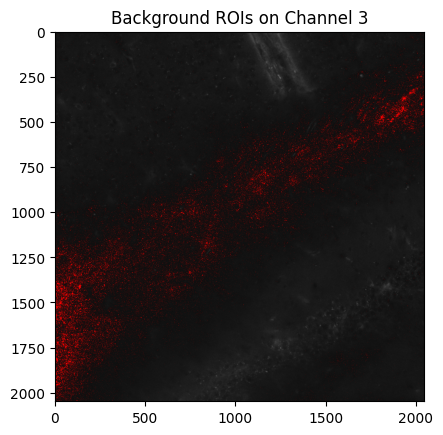

In [7]:
# Find minima below a threshold to define background ROIs
background_threshold = 127  # Adjust this value based on your needs
background_thresh = channel3 < background_threshold

# Label the background regions
background_labels = measure.label(background_thresh)
background_props = measure.regionprops(background_labels)

# Create bounding boxes around the detected background contours to define background ROIs
background_rois = []

for prop in background_props:
    minr, minc, maxr, maxc = prop.bbox[:4]
    background_rois.append((minc, minr, maxc - minc, maxr - minr))

# Display background ROIs on channel 1
background_roi_image = np.stack([normalize(channel3)]*3, axis=-1)  # Convert to RGB

for roi in background_rois:
    x, y, w, h = roi
    background_roi_image[y:y+h, x:x+w] = [1, 0, 0]  # Red for background ROIs

print("the amount of found Background ROIs is:" + str(len(background_rois)))

plt.imshow(background_roi_image)
plt.title('Background ROIs on Channel 3')
plt.show()


In [8]:
# Initialize a list to store mean fluorescence values
mean_fluorescence = {f'Channel {i+1}': [] for i in range(image.shape[2])}
background_values = {f'Channel {i+1}': [] for i in range(image.shape[2])}
integrated_intensity = {f'Channel {i+1}': [] for i in range(image.shape[2])}
ctcf_values = {f'Channel {i+1}': [] for i in range(image.shape[2])}
roi_areas = {f'Channel {i+1}': [] for i in range(image.shape[2])}

In [9]:
# Calculate mean background values for each channel
for channel_index in range(image.shape[2]):
    channel = image[:, :, channel_index]
    
    for roi in background_rois:
        x, y, w, h = roi
        roi_area = channel[y:y+h, x:x+w]
        mean_background = np.mean(roi_area)
        background_values[f'Channel {channel_index+1}'].append(mean_background)

mean_background_value = []
# Subtract background from the entire image
background_subtracted_image = np.copy(image)
for channel_index in range(image.shape[2]):
    mean_background_value.append(np.mean(background_values[f'Channel {channel_index+1}']))
    print(f'"for channel {channel_index+1} the mean background is: {mean_background_value[channel_index]}"')
    background_subtracted_image[:, :, channel_index] -= np.minimum(math.floor(mean_background_value[channel_index]), background_subtracted_image[:, :, channel_index])

"for channel 1 the mean background is: 323.2064457904791"
"for channel 2 the mean background is: 230.31484766930637"
"for channel 3 the mean background is: 123.45550823078842"


In [10]:
print(np.amax(background_subtracted_image))
print(np.amin(background_subtracted_image))

2647
0


the amount of found ROIs is:20


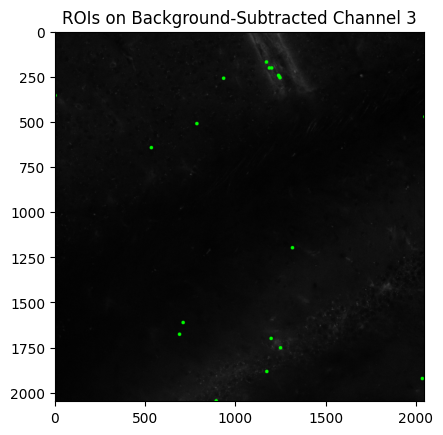

In [13]:
# Apply thresholds to find maximum values in the background-subtracted channel 1, avoiding very bright spots
lower_thresh = 400  # Adjust this value based on your needs
upper_thresh = 10020  # Adjust this value based on your needs
radius_factor = 1  # Adjust this value based on your needs

# Mask out very bright spots
thresh = (background_subtracted_image[:, :, 2] > lower_thresh) & (background_subtracted_image[:, :, 2] < upper_thresh)

# Label the thresholded regions
labels = measure.label(thresh)
props = measure.regionprops(labels)

# Create circular ROIs around detected points
rois = []

for prop in props:
    y, x = prop.centroid
    radius = 10 # radius_factor * np.sqrt(prop.area / np.pi)
    rois.append((int(x), int(y), int(radius)))

# Display circular ROIs on the background-subtracted channel 3
roi_image = np.stack([normalize(background_subtracted_image[:, :, 2])]*3, axis=-1)  # Convert to RGB

for roi in rois:
    x, y, radius = roi
    rr, cc = draw.disk((y, x), radius, shape=roi_image.shape)
    roi_image[rr, cc] = [0, 1, 0]  # Green for ROIs


print("the amount of found ROIs is:" + str(len(rois)))

plt.imshow(roi_image)
plt.title('ROIs on Background-Subtracted Channel 3')
plt.show()

In [12]:
# Measure mean fluorescence in the ROIs for all channels
for channel_index in range(image.shape[2]):
    channel = background_subtracted_image[:, :, channel_index]

    for roi in rois:
        x, y, radius = roi
        rr, cc = draw.disk((y, x), radius, shape=channel.shape)
        roi_area = channel[rr, cc]
        integrated_value = np.sum(roi_area)
        area = len(rr)
        mean_background_value = np.mean(background_values[f'Channel {channel_index+1}'])
        ctcf_value = integrated_value - (area * mean_background_value)

        integrated_intensity[f'Channel {channel_index+1}'].append(integrated_value)
        roi_areas[f'Channel {channel_index+1}'].append(area)
        ctcf_values[f'Channel {channel_index+1}'].append(ctcf_value)
        # mean_value = np.mean(roi_area)
        # mean_fluorescence[f'Channel {channel_index+1}'].append(mean_value)

results = []

# Collect results into a list of dictionaries for easy conversion to DataFrame
result = {'Base Name': base_name}
for channel, values in integrated_intensity.items():
    result[f'{channel} Integrated Intensity'] = np.sum(values)
    result[f'{channel} ROI Areas'] = np.sum(roi_areas[channel])
    result[f'{channel} Mean Background'] = np.mean(background_values[channel])
    result[f'{channel} CTCF'] = np.sum(ctcf_values[channel])
results.append(result)

# Convert the results to a DataFrame and save to CSV

# Convert the results to a DataFrame and save to CSV
df = pd.DataFrame(results)
df.to_csv(os.path.join(os.getcwd(), 'integrated_intensity_results.csv'), index=False)